# Non-trivial models boundary operators

Created 29/04/2025

Objectives:
* Investigate boundary operators and extract SPT phase.

# Package imports

In [1]:
import sys
sys.path.append('../')

In [2]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os
import pickle

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

In [4]:
from tqdm import tqdm

In [5]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.utils import (
    to_npc_array,
    get_right_identity_environment,
    get_right_identity_environment_from_tp_tensor,
    multiply_stacked_unitaries_against_mps,
    inner_product_b_tensors,
    get_npc_identity_operator
)

from SPTOptimization.Optimizers.MPSBrickSolver import(
    MPSBrickSolver
)

# Load data

In [6]:
DATA_DIR_1 = r"../data/interpolated_trivial_to_nontrivial_fermionic_trivial_proj_rep_200_site_dmrg/"
DATA_DIR_2 = r"../data/interpolated_nontrivial_fermionic_proj_rep_to_nontrivial_proj_rep_200_site_dmrg/"

In [7]:
def parse_file_name(file_name):
    interpolation = int(file_name.split('_')[0])/100

    return interpolation

In [8]:
loaded_data_triv_proj_rep = dict()
energies_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_1))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_1, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_triv_proj_rep[data_info]=data['wavefunction']
        energies_triv_proj_rep[data_info]=data['energy']

In [9]:
loaded_data_non_triv_proj_rep = dict()
energies_non_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_2))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_2, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_non_triv_proj_rep[data_info]=data['wavefunction']
        energies_non_triv_proj_rep[data_info]=data['energy']

# Definitons

In [10]:
MAX_VIRTUAL_BOND_DIM = 30
MAX_INTERMEDIATE_VIRTUAL_BOND_DIM = 2*MAX_VIRTUAL_BOND_DIM
# MPO bond dim?
MAX_MPO_BOND_DIM = 50

SVD_CUTOFF = 1e-3

Define bosonic symmetries. Label by the group element added.

In [11]:
np_00 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

np_01 = np.array([
    [0, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

np_10 = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

np_11 = np.array([
    [0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [1, 0, 0, 0]
])

In [12]:
bosonic_np_symmetries = [
    np_00,
    np_01,
    np_10,
    np_11
]

In [13]:
bosonic_npc_symmetries = [
    to_npc_array(X) for X in bosonic_np_symmetries
]

In [14]:
npc_00 = to_npc_array(np_00)
npc_01 = to_npc_array(np_01)
npc_10 = to_npc_array(np_10)
npc_11 = to_npc_array(np_11)

Define "fermionic symmetries". Just identity and JW string.

In [15]:
np_I = np.array([
    [1, 0],
    [0, 1]
])

np_JW = np.array([
    [1, 0],
    [0, -1]
])

In [16]:
fermionic_np_symmetries = [np_I, np_JW]

In [17]:
fermionic_npc_symmetries = [
    to_npc_array(X) for X in fermionic_np_symmetries
]

In [18]:
npc_JW = fermionic_npc_symmetries[1]

In [19]:
symmetry_actions = [
    [[b, f] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [20]:
shifted_symmetry_actions = [
    [[f, b] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [21]:
cases_triv_proj_rep = dict()

for k, psi in loaded_data_triv_proj_rep.items():

    for i, l in enumerate(symmetry_actions):

        for j, s in enumerate(l):
            case = SymmetryActionWithBoundaryUnitaries(
                psi,
                s*40,
                left_symmetry_index=60,
                left_boundary_unitaries=[np_I, np_00]*1,
                right_boundary_unitaries=[np_00, np_I]*1
            )

            cases_triv_proj_rep[(k, i, j)] = case

In [22]:
for c in cases_triv_proj_rep.values():
    c.compute_svd_approximate_expectation()

In [23]:
cases_non_triv_proj_rep = dict()

for k, psi in loaded_data_non_triv_proj_rep.items():

    for i, l in enumerate(symmetry_actions):

        for j, s in enumerate(l):
            case = SymmetryActionWithBoundaryUnitaries(
                psi,
                s*40,
                left_symmetry_index=60,
                left_boundary_unitaries=[np_I, np_00]*1,
                right_boundary_unitaries=[np_00, np_I]*1
            )

            cases_non_triv_proj_rep[(k, i, j)] = case

In [24]:
for c in cases_non_triv_proj_rep.values():
    c.compute_svd_approximate_expectation()

In [25]:
left_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=1
)

In [26]:
right_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=-1
)

## SPT functions

In [27]:
def calculate_proj_rep_phase(state_g, left_schmidt_values_g, unitary_h,
                             state_gh,
                             left_environment,
                             max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM):
    prod_state, _ = multiply_stacked_unitaries_against_mps(
        unitary_h,
        state_g,
        left_schmidt_values_g,
        max_virtual_bond_dim
    )

    exp = inner_product_b_tensors(prod_state, state_gh, left_environment)

    return exp/(np.abs(exp))

In [28]:
def get_proj_rep_phases(mps_tensors, left_schmidt_values, unitaries,
                        left_environment):
    mps_dict = {
        k: v for k, v in zip(symmetry_labels[1:], mps_tensors)
    }

    schmidt_vals_dict = {
        k: v for k, v in zip(symmetry_labels[1:], left_schmidt_values)
    }

    unitaries_dict = {
        k: v for k, v in zip(symmetry_labels[1:], unitaries)
    }

    out_phases = list()

    for a, b, c in group_products:
        phase = calculate_proj_rep_phase(
            mps_dict[a],
            schmidt_vals_dict[a],
            unitaries_dict[b],
            mps_dict[c],
            left_environment,
            max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM
        )

        out_phases.append(phase)

    return out_phases

In [29]:
def get_right_proj_rep_phases_from_optimizers(optimizers):
    mps_tensors = [
        o.top_right_mps_tensors
        for o in optimizers[1:]
    ]

    left_schmidt_values = [
        o.current_right_side_left_schmidt_values
        for o in optimizers[1:]
    ]

    unitaries = [
        o.right_unitaries for o in optimizers[1:]
    ]

    left_environment = optimizers[0].right_side_left_symmetry_environment

    out = get_proj_rep_phases(
        mps_tensors,
        left_schmidt_values,
        unitaries,
        left_environment
    )

    return out

In [30]:
def get_left_proj_rep_phases_from_optimizers(optimizers):
    mps_tensors = [
        o.top_left_mps_tensors
        for o in optimizers[1:]
    ]

    left_schmidt_values = [
        o.current_left_side_right_schmidt_values
        for o in optimizers[1:]
    ]

    unitaries = [
        o.left_unitaries for o in optimizers[1:]
    ]

    left_environment = optimizers[0].left_side_right_symmetry_environment

    out = get_proj_rep_phases(
        mps_tensors,
        left_schmidt_values,
        unitaries,
        left_environment
    )

    return out

## Group data definitions

In [31]:
from itertools import combinations

In [32]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [33]:
symmetry_combination_labels = list(combinations(symmetry_labels, 2))

In [34]:
symmetry_combination_labels

[('II', 'IX'),
 ('II', 'XI'),
 ('II', 'XX'),
 ('IX', 'XI'),
 ('IX', 'XX'),
 ('XI', 'XX')]

In [35]:
e, a, b, c = symmetry_labels

In [36]:
group_products = [
    (a, b, c),
    (b, a, c),
    (a, c, b),
    (c, a, b),
    (c, b, a),
    (b, c, a)
]

In [37]:
symmetry_pair_labels = [
    a + ',' + b,
    a + ',' + c,
    c + ',' + b
]

# Calculate boundary operators

In [38]:
block_width = 3
num_one_sided_iterations = 3
num_two_sided_iterations = 3
num_layers = 4
num_sites = 15
max_virtual_bond_dim = 30

In [39]:
"""
optimizer_dict_triv_proj_rep = dict()

for k, v in cases_triv_proj_rep.items():
    opt = MPSBrickSolver(
        v,
        num_sites,
        block_width,
        num_layers,
        num_one_sided_iterations,
        num_two_sided_iterations,
        max_virtual_bond_dim=max_virtual_bond_dim
    )

    opt.optimise()

    optimizer_dict_triv_proj_rep[k] = opt
"""

'\noptimizer_dict_triv_proj_rep = dict()\n\nfor k, v in cases_triv_proj_rep.items():\n    opt = MPSBrickSolver(\n        v,\n        num_sites,\n        block_width,\n        num_layers,\n        num_one_sided_iterations,\n        num_two_sided_iterations,\n        max_virtual_bond_dim=max_virtual_bond_dim\n    )\n\n    opt.optimise()\n\n    optimizer_dict_triv_proj_rep[k] = opt\n'

In [40]:
"""
optimizer_dict_non_triv_proj_rep = dict()

for k, v in cases_non_triv_proj_rep.items():
    opt = MPSBrickSolver(
        v,
        num_sites,
        block_width,
        num_layers,
        num_one_sided_iterations,
        num_two_sided_iterations,
        max_virtual_bond_dim=max_virtual_bond_dim
    )

    opt.optimise()

    optimizer_dict_non_triv_proj_rep[k] = opt
"""

'\noptimizer_dict_non_triv_proj_rep = dict()\n\nfor k, v in cases_non_triv_proj_rep.items():\n    opt = MPSBrickSolver(\n        v,\n        num_sites,\n        block_width,\n        num_layers,\n        num_one_sided_iterations,\n        num_two_sided_iterations,\n        max_virtual_bond_dim=max_virtual_bond_dim\n    )\n\n    opt.optimise()\n\n    optimizer_dict_non_triv_proj_rep[k] = opt\n'

Save results.

In [41]:
"""
with open(r'solutions/non_trivial_models_triv_proj_rep_brick_sol_30_bond_dim_dict.pkl', 'wb') as file:
    pickle.dump(optimizer_dict_triv_proj_rep, file)
"""

"\nwith open(r'solutions/non_trivial_models_triv_proj_rep_brick_sol_30_bond_dim_dict.pkl', 'wb') as file:\n    pickle.dump(optimizer_dict_triv_proj_rep, file)\n"

In [42]:
"""
with open(r'solutions/non_trivial_models_non_triv_proj_rep_brick_sol_30_bond_dim_dict.pkl', 'wb') as file:
    pickle.dump(optimizer_dict_non_triv_proj_rep, file)
"""

"\nwith open(r'solutions/non_trivial_models_non_triv_proj_rep_brick_sol_30_bond_dim_dict.pkl', 'wb') as file:\n    pickle.dump(optimizer_dict_non_triv_proj_rep, file)\n"

In [43]:
with open(r'solutions/non_trivial_models_triv_proj_rep_brick_sol_30_bond_dim_dict.pkl', 'rb') as file:
    optimizer_dict_triv_proj_rep = pickle.load(file)

with open(r'solutions/non_trivial_models_non_triv_proj_rep_brick_sol_30_bond_dim_dict.pkl', 'rb') as file:
    optimizer_dict_non_triv_proj_rep = pickle.load(file)

## Expectations

In [44]:
interpolation_values = np.round(np.linspace(0, 1, 21), 3)

In [45]:
final_exps_triv_proj_rep = dict()

for k, v in optimizer_dict_triv_proj_rep.items():
    final_exp = v.flatten_exps()[-1]
    final_exps_triv_proj_rep[k] = final_exp

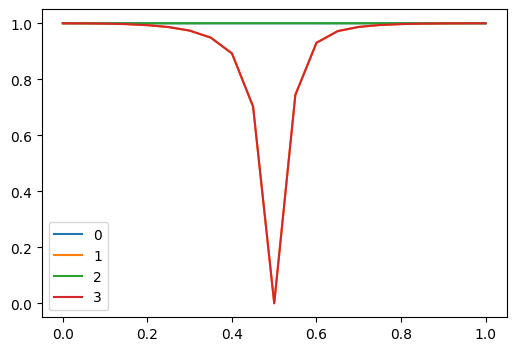

In [46]:
fig, ax = plt.subplots(figsize=(6, 4))

for i in range(4):
    l = [final_exps_triv_proj_rep[(t, 0, i)] for t in interpolation_values]
    ax.plot(interpolation_values, l, label=i)

ax.legend()

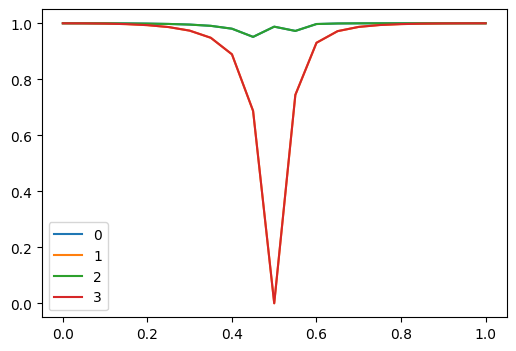

In [47]:
fig, ax = plt.subplots(figsize=(6, 4))

for i in range(4):
    l = [final_exps_triv_proj_rep[(t, 1, i)] for t in interpolation_values]
    ax.plot(interpolation_values, l, label=i)

ax.legend()

The (0, 2) and (1,3) symmetries have the same result, as expected as they have the same action on the state!

In [48]:
final_exps_non_triv_proj_rep = dict()

for k, v in optimizer_dict_non_triv_proj_rep.items():
    final_exp = v.flatten_exps()[-1]
    final_exps_non_triv_proj_rep[k] = final_exp

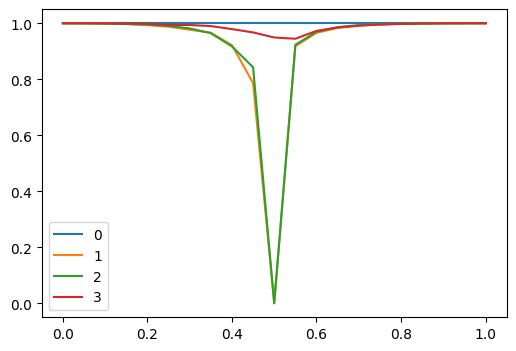

In [49]:
fig, ax = plt.subplots(figsize=(6, 4))

for i in range(4):
    l = [final_exps_non_triv_proj_rep[(t, 0, i)] for t in interpolation_values]
    ax.plot(interpolation_values, l, label=i)

ax.legend()

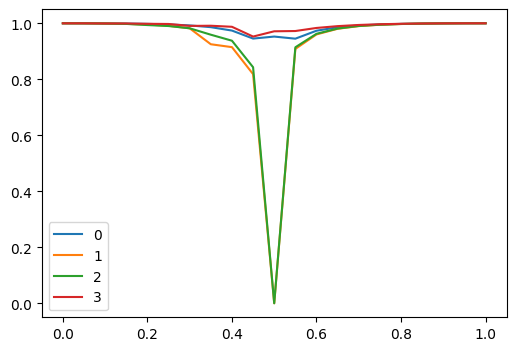

In [50]:
fig, ax = plt.subplots(figsize=(6, 4))

for i in range(4):
    l = [final_exps_non_triv_proj_rep[(t, 1, i)] for t in interpolation_values]
    ax.plot(interpolation_values, l, label=i)

ax.legend()

Difference with/without the JW string in this case.

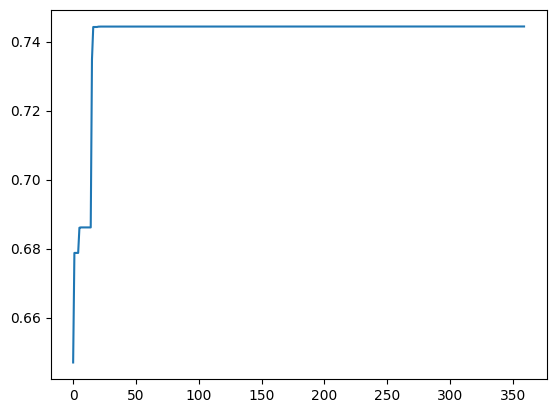

In [51]:
plt.plot(optimizer_dict_triv_proj_rep[(0.55, 1, 1)].flatten_exps())

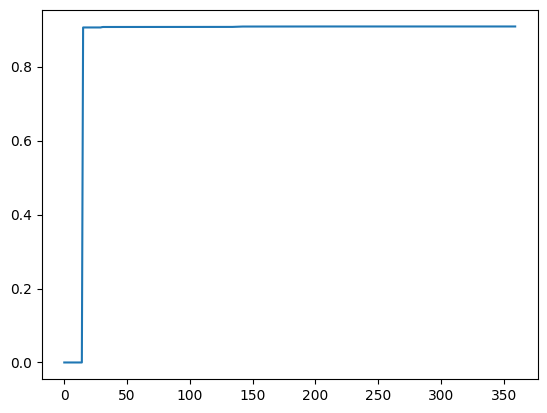

In [52]:
plt.plot(optimizer_dict_non_triv_proj_rep[(0.55, 1, 1)].flatten_exps())

## Fermionic cohomology

In [53]:
def right_fp_charge(optimizer):
    opt = optimizer

    base_bs = opt.bottom_right_mps_tensors

    fp_bs = list()
    
    for i, b in enumerate(base_bs):
        # Need to update this logic
        if i%2:
            b_to_add = npc.tensordot(b, npc_JW, [['p',], ['p*',]])
        else:
            b_to_add = b
    
        fp_bs.append(b_to_add)

    fp_o_bs, _ = multiply_stacked_unitaries_against_mps(
        opt.right_unitaries,
        fp_bs,
        opt.original_right_side_left_schmidt_values,
        opt.max_virtual_bond_dim
    )

    out = inner_product_b_tensors(
        fp_o_bs,
        fp_bs,
        left_environment=opt.right_side_left_symmetry_environment
    )

    return out

In [54]:
right_fp_triv_proj_rep_charges = dict()

for k, v in tqdm(optimizer_dict_triv_proj_rep.items()):
    right_fp_triv_proj_rep_charges[k] = right_fp_charge(v)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [01:04<00:00,  2.62it/s]


In [55]:
right_fp_non_triv_proj_rep_charges = dict()

for k, v in tqdm(optimizer_dict_non_triv_proj_rep.items()):
    right_fp_non_triv_proj_rep_charges[k] = right_fp_charge(v)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [08:58<00:00,  3.20s/it]


In [56]:
right_fp_triv_proj_rep_charges_list = list()

for t in interpolation_values:
    l0 = [right_fp_triv_proj_rep_charges[(t,0,i)] for i in range(4)]
    l1 = [right_fp_triv_proj_rep_charges[(t,1,i)] for i in range(4)]
    
    right_fp_triv_proj_rep_charges_list.append([l0, l1])

right_fp_triv_proj_rep_charges_array = np.array(right_fp_triv_proj_rep_charges_list)

In [57]:
np.real(np.round(right_fp_triv_proj_rep_charges_array, 2))

array([[[ 1.  , -1.  ,  1.  , -1.  ],
        [ 1.  , -1.  ,  1.  , -1.  ]],

       [[ 1.  , -1.  ,  1.  , -1.  ],
        [ 1.  , -1.  ,  1.  , -1.  ]],

       [[ 1.  , -1.  ,  1.  , -1.  ],
        [ 1.  , -1.  ,  1.  , -1.  ]],

       [[ 1.  , -1.  ,  1.  , -1.  ],
        [ 1.  , -1.  ,  1.  , -1.  ]],

       [[ 1.  , -0.99,  1.  , -0.99],
        [ 1.  , -0.99,  1.  , -0.99]],

       [[ 1.  , -0.99,  1.  , -0.99],
        [ 1.  , -0.99,  1.  , -0.99]],

       [[ 1.  , -0.97,  1.  , -0.97],
        [ 1.  , -0.97,  1.  , -0.97]],

       [[ 1.  , -0.95,  1.  , -0.95],
        [ 0.99, -0.95,  0.99, -0.95]],

       [[ 1.  , -0.89,  1.  , -0.89],
        [ 0.98, -0.89,  0.98, -0.89]],

       [[ 1.  , -0.7 ,  1.  , -0.7 ],
        [ 0.95, -0.69,  0.95, -0.69]],

       [[ 1.  ,  0.  ,  1.  ,  0.  ],
        [ 0.99,  0.  ,  0.99,  0.  ]],

       [[ 1.  ,  0.74,  1.  ,  0.74],
        [ 0.97,  0.74,  0.97,  0.74]],

       [[ 1.  ,  0.93,  1.  ,  0.93],
        [ 1.  ,  0.93,  1.

In [58]:
right_fp_non_triv_proj_rep_charges_list = list()

for t in interpolation_values:
    l0 = [right_fp_non_triv_proj_rep_charges[(t,0,i)] for i in range(4)]
    l1 = [right_fp_non_triv_proj_rep_charges[(t,1,i)] for i in range(4)]
    
    right_fp_non_triv_proj_rep_charges_list.append([l0, l1])

right_fp_non_triv_proj_rep_charges_array = np.array(right_fp_non_triv_proj_rep_charges_list)

In [59]:
np.real(np.round(right_fp_non_triv_proj_rep_charges_array, 2))

array([[[ 1.  ,  1.  , -1.  , -1.  ],
        [ 1.  ,  1.  , -1.  , -1.  ]],

       [[ 1.  ,  1.  , -1.  , -1.  ],
        [ 1.  ,  1.  , -1.  , -1.  ]],

       [[ 1.  ,  1.  , -1.  , -1.  ],
        [ 1.  ,  1.  , -1.  , -1.  ]],

       [[ 1.  ,  1.  , -1.  , -1.  ],
        [ 1.  ,  1.  , -1.  , -1.  ]],

       [[ 1.  ,  0.99, -0.99, -1.  ],
        [ 1.  ,  1.  , -0.99, -1.  ]],

       [[ 1.  ,  0.99, -0.99, -0.99],
        [ 1.  ,  0.99, -0.99, -1.  ]],

       [[ 1.  ,  0.98, -0.98, -0.99],
        [ 0.99,  0.98, -0.98, -0.99]],

       [[ 1.  ,  0.97, -0.96, -0.99],
        [ 0.99,  0.93, -0.96, -0.99]],

       [[ 1.  ,  0.92, -0.92, -0.98],
        [ 0.97,  0.91, -0.94, -0.99]],

       [[ 1.  ,  0.79, -0.84, -0.97],
        [ 0.95,  0.82, -0.84, -0.95]],

       [[ 1.  ,  0.  , -0.  , -0.95],
        [ 0.95,  0.  , -0.  , -0.97]],

       [[ 1.  , -0.92,  0.92, -0.94],
        [ 0.95, -0.91,  0.91, -0.97]],

       [[ 1.  , -0.97,  0.97, -0.97],
        [ 0.97, -0.96,  0.

Looks good!

## Extract phases

In [60]:
right_fp_triv_proj_rep_charges_dict = dict()

for i, t in enumerate(interpolation_values):
    for j in range(4):
        charge = right_fp_triv_proj_rep_charges_array[i, 0, j]
        sign_charge = 1 if charge > 0 else -1
    
        right_fp_triv_proj_rep_charges_dict[(t, j)] = sign_charge

In [61]:
right_fp_non_triv_proj_rep_charges_dict = dict()

for i, t in enumerate(interpolation_values):
    for j in range(4):
        charge = right_fp_non_triv_proj_rep_charges_array[i, 0, j]
        sign_charge = 1 if charge > 0 else -1
    
        right_fp_non_triv_proj_rep_charges_dict[(t, j)] = sign_charge

## Left side

In [62]:
def left_fp_charge(optimizer):
    opt = optimizer

    base_bs = opt.bottom_left_mps_tensors

    fp_bs = list()
    
    for i, b in enumerate(base_bs):
        # Need to update this logic
        if (i%2 == 0):
            b_to_add = npc.tensordot(b, npc_JW, [['p',], ['p*',]])
        else:
            b_to_add = b
    
        fp_bs.append(b_to_add)

    fp_o_bs, _ = multiply_stacked_unitaries_against_mps(
        opt.left_unitaries,
        fp_bs,
        opt.original_left_side_right_schmidt_values,
        opt.max_virtual_bond_dim
    )

    out = inner_product_b_tensors(
        fp_o_bs,
        fp_bs,
        left_environment=opt.left_side_right_symmetry_environment
    )

    return out

In [63]:
left_fp_triv_proj_rep_charges = dict()

for k, v in tqdm(optimizer_dict_triv_proj_rep.items()):
    left_fp_triv_proj_rep_charges[k] = left_fp_charge(v)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [30:50<00:00, 11.02s/it]


In [64]:
left_fp_non_triv_proj_rep_charges = dict()

for k, v in tqdm(optimizer_dict_non_triv_proj_rep.items()):
    left_fp_non_triv_proj_rep_charges[k] = left_fp_charge(v)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [49:51<00:00, 17.81s/it]


In [65]:
left_fp_triv_proj_rep_charges_list = list()

for t in interpolation_values:
    l0 = [left_fp_triv_proj_rep_charges[(t,0,i)] for i in range(4)]
    l1 = [left_fp_triv_proj_rep_charges[(t,1,i)] for i in range(4)]
    
    left_fp_triv_proj_rep_charges_list.append([l0, l1])

left_fp_triv_proj_rep_charges_array = np.array(left_fp_triv_proj_rep_charges_list)

In [66]:
left_fp_non_triv_proj_rep_charges_list = list()

for t in interpolation_values:
    l0 = [left_fp_non_triv_proj_rep_charges[(t,0,i)] for i in range(4)]
    l1 = [left_fp_non_triv_proj_rep_charges[(t,1,i)] for i in range(4)]
    
    left_fp_non_triv_proj_rep_charges_list.append([l0, l1])

left_fp_non_triv_proj_rep_charges_array = np.array(left_fp_non_triv_proj_rep_charges_list)

In [67]:
left_fp_triv_proj_rep_charges_dict = dict()

for i, t in enumerate(interpolation_values):
    for j in range(4):
        charge = left_fp_triv_proj_rep_charges_array[i, 0, j]
        sign_charge = 1 if charge > 0 else -1
    
        left_fp_triv_proj_rep_charges_dict[(t, j)] = sign_charge

In [68]:
left_fp_non_triv_proj_rep_charges_dict = dict()

for i, t in enumerate(interpolation_values):
    for j in range(4):
        charge = left_fp_non_triv_proj_rep_charges_array[i, 0, j]
        sign_charge = 1 if charge > 0 else -1
    
        left_fp_non_triv_proj_rep_charges_dict[(t, j)] = sign_charge

In [69]:
(
    left_fp_triv_proj_rep_charges_dict == right_fp_triv_proj_rep_charges_dict,
    left_fp_non_triv_proj_rep_charges_dict == right_fp_non_triv_proj_rep_charges_dict
)

(True, True)

Great, they agree so we only need one going forward.

Combine into single array.

In [70]:
fp_triv_proj_rep_charges_array = np.stack(
    [left_fp_triv_proj_rep_charges_array, right_fp_triv_proj_rep_charges_array],
    axis=-1
)

fp_non_triv_proj_rep_charges_array = np.stack(
    [left_fp_non_triv_proj_rep_charges_array, right_fp_non_triv_proj_rep_charges_array],
    axis=-1
)

fp_charges_array = np.stack(
    [fp_triv_proj_rep_charges_array, fp_non_triv_proj_rep_charges_array],
    axis=0
)

In [71]:
fp_charges_array.shape

(2, 21, 2, 4, 2)

In [72]:
fp_charges_array[:, 10, ...]

array([[[[ 1.00000000e+00+0.00000000e+00j,
           1.00000000e+00+0.00000000e+00j],
         [ 1.09182301e-05+0.00000000e+00j,
           1.09182301e-05+0.00000000e+00j],
         [ 1.00000000e+00+0.00000000e+00j,
           1.00000000e+00+0.00000000e+00j],
         [ 1.09182301e-05+0.00000000e+00j,
           1.09182301e-05+0.00000000e+00j]],

        [[ 9.87906956e-01+0.00000000e+00j,
           9.87906956e-01+0.00000000e+00j],
         [ 1.09160011e-05+0.00000000e+00j,
           1.09160011e-05+0.00000000e+00j],
         [ 9.87906903e-01+0.00000000e+00j,
           9.87906903e-01+0.00000000e+00j],
         [ 1.09160011e-05+0.00000000e+00j,
           1.09160011e-05+0.00000000e+00j]]],


       [[[ 1.00000000e+00-7.05717419e-16j,
           1.00000000e+00-3.48656933e-16j],
         [ 1.30492257e-04-2.25330650e-11j,
           1.30492257e-04-2.25330648e-11j],
         [-1.26964600e-04+3.46639543e-11j,
          -1.26964600e-04+3.46639544e-11j],
         [-9.49294839e-01-6.45049017e

In [73]:
fp_charges_array = np.delete(fp_charges_array, 10, axis=1)

In [74]:
fp_charges_array.shape

(2, 20, 2, 4, 2)

In [75]:
np.max(np.abs(fp_charges_array[..., 0] - fp_charges_array[..., 1]))

8.372702234514765e-15

In [76]:
fp_charges_array = fp_charges_array[..., 0]

In [77]:
np.max(np.abs(fp_charges_array[..., 0, :] - fp_charges_array[..., 1, :]))

0.05498764233237323

In [78]:
np.max(np.abs(np.imag(fp_charges_array)))

1.0706960997367053e-06

In [79]:
fp_charges_array = np.real(fp_charges_array)

In [80]:
np.min(np.abs(fp_charges_array))

0.6871050496090014

In [81]:
fp_charges_array.shape

(2, 20, 2, 4)

In [82]:
sub_fp_charges_array = fp_charges_array[..., 0, 1:]

In [83]:
sub_fp_charges_array.shape

(2, 20, 3)

In [84]:
sub_fp_charges_array[0, :10, 0] *= -1
sub_fp_charges_array[0, :10, 2] *= -1

In [85]:
sub_fp_charges_array[1, 10:, 0] *= -1
sub_fp_charges_array[1, 10:, 2] *= -1

In [86]:
sub_fp_charges_array[1, :10, 1] *= -1
sub_fp_charges_array[1, :10, 2] *= -1

In [87]:
np.all(sub_fp_charges_array > 0)

True

In [88]:
colors = [
    'tab:blue',
    'tab:orange',
    'tab:green'
]   

In [89]:
interpolation_values = np.delete(interpolation_values, 10)

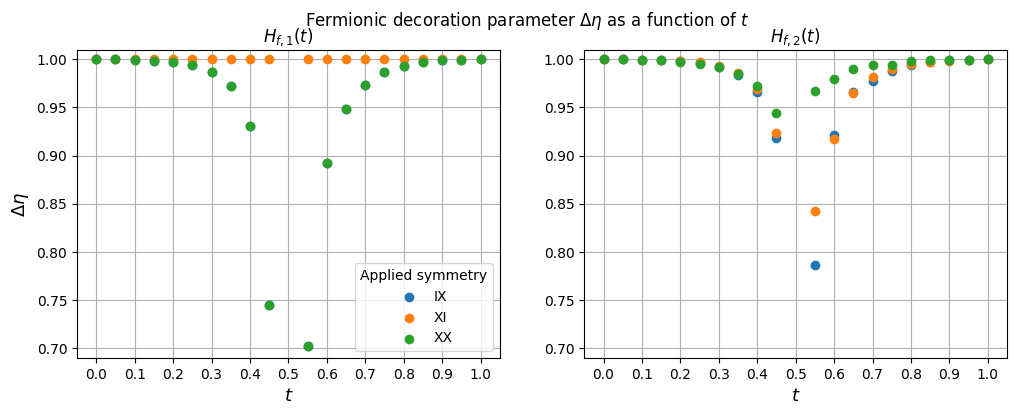

In [90]:
fig, [ax1, ax2] = plt.subplots(figsize=(12,4), ncols=2)

for k, ax in enumerate([ax1, ax2]):
    for j, (col, label) in enumerate(zip(colors, symmetry_labels[1:])):
        ax.scatter(
            1-interpolation_values, # I ordered this wrong at definition
            sub_fp_charges_array[k, :, j],
            color=col,
            label=label
        )

    ax.set_ylim(0.69, 1.01)
    ax.xaxis.set_major_locator(MultipleLocator(0.1))
    
    #ax.set_yscale('log')
    
    ax.grid()
    ax.grid(
        which='minor',
        axis='y',
        linestyle='--',
        zorder=-1e10
    )
    ax.set_axisbelow(True)

    if k == 0:
        ax.set_ylabel(r'$\Delta\eta$', fontsize=13)
    ax.set_xlabel('$t$', fontsize=13)

    if k == 0:
        ax.legend(loc='lower right', title='Applied symmetry')

    ax.title.set_text(rf'$H_{{f,{k+1}}}(t)$')

fig.suptitle(r'Fermionic decoration parameter $\Delta\eta$ as a function of $t$')

fig.savefig(r'plots/fermion_decoration_parameter_unitary_circuit.png', dpi=200)

# Calculate proj reps

## Right side

In [91]:
right_triv_proj_rep_phases = list()

for t in interpolation_values:
    optimizers = list()
    for j in range(4):
        jw_phase = right_fp_triv_proj_rep_charges_dict[(t, j)]
        jw = 1 if jw_phase < 0 else 0

        opt = optimizer_dict_triv_proj_rep[(t, jw, j)]

        optimizers.append(opt)

    phases = get_right_proj_rep_phases_from_optimizers(optimizers)

    right_triv_proj_rep_phases.append(phases)

right_triv_proj_rep_phases = np.array(right_triv_proj_rep_phases)

In [92]:
right_triv_proj_rep_phases.shape

(20, 6)

In [93]:
right_triv_proj_rep_phases

array([[ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j],
       [-1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j],
       [-1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1

In [94]:
right_triv_proj_rep_phases[:, ::2]/right_triv_proj_rep_phases[:, 1::2]

array([[1.+0.j, 1.-0.j, 1.+0.j],
       [1.+0.j, 1.-0.j, 1.+0.j],
       [1.+0.j, 1.-0.j, 1.+0.j],
       [1.+0.j, 1.-0.j, 1.+0.j],
       [1.+0.j, 1.-0.j, 1.+0.j],
       [1.-0.j, 1.+0.j, 1.-0.j],
       [1.+0.j, 1.-0.j, 1.+0.j],
       [1.+0.j, 1.-0.j, 1.+0.j],
       [1.-0.j, 1.+0.j, 1.-0.j],
       [1.+0.j, 1.-0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j]])

In [95]:
right_non_triv_proj_rep_phases = list()

for t in interpolation_values:
    optimizers = list()
    for j in range(4):
        jw_phase = right_fp_non_triv_proj_rep_charges_dict[(t, j)]
        jw = 1 if jw_phase < 0 else 0

        opt = optimizer_dict_non_triv_proj_rep[(t, jw, j)]

        optimizers.append(opt)

    phases = get_right_proj_rep_phases_from_optimizers(optimizers)

    right_non_triv_proj_rep_phases.append(phases)

right_non_triv_proj_rep_phases = np.array(right_non_triv_proj_rep_phases)

In [96]:
right_non_triv_proj_rep_phases.shape

(20, 6)

In [97]:
np.round(right_non_triv_proj_rep_phases, 2)

array([[ 0.02+1.j  , -0.02-1.j  , -0.02-1.j  ,  0.02+1.j  ,  0.02-1.j  ,
        -0.02+1.j  ],
       [ 0.  -1.j  , -0.  +1.j  ,  0.  +1.j  , -0.  -1.j  , -0.  +1.j  ,
         0.  -1.j  ],
       [-0.01+1.j  ,  0.01-1.j  ,  0.  -1.j  , -0.  +1.j  , -0.  -1.j  ,
         0.  +1.j  ],
       [ 0.  -1.j  , -0.  +1.j  , -0.  +1.j  ,  0.  -1.j  , -0.  +1.j  ,
         0.  -1.j  ],
       [ 0.  -1.j  , -0.  +1.j  ,  0.  +1.j  , -0.  -1.j  ,  0.  +1.j  ,
        -0.  -1.j  ],
       [ 0.01-1.j  , -0.01+1.j  ,  0.  +1.j  , -0.  -1.j  , -0.  +1.j  ,
         0.  -1.j  ],
       [ 0.  -1.j  , -0.  +1.j  ,  0.  +1.j  , -0.  -1.j  , -0.  +1.j  ,
         0.  -1.j  ],
       [ 0.  +1.j  , -0.  -1.j  , -0.  -1.j  ,  0.  +1.j  ,  0.  -1.j  ,
        -0.  +1.j  ],
       [ 0.01-1.j  , -0.01+1.j  ,  0.01+1.j  , -0.01-1.j  , -0.01+1.j  ,
         0.01-1.j  ],
       [-0.  -1.j  ,  0.  +1.j  , -0.  +1.j  ,  0.  -1.j  , -0.  +1.j  ,
         0.  -1.j  ],
       [ 1.  -0.j  ,  1.  -0.j  ,  1.  -0.j  ,  1.

Why are these phases so clean...

In [98]:
np.round(
    right_non_triv_proj_rep_phases[:, ::2]/right_non_triv_proj_rep_phases[:, 1::2],
    2
)

array([[-1.+0.j, -1.-0.j, -1.-0.j],
       [-1.-0.j, -1.-0.j, -1.-0.j],
       [-1.+0.j, -1.-0.j, -1.-0.j],
       [-1.-0.j, -1.+0.j, -1.-0.j],
       [-1.+0.j, -1.+0.j, -1.+0.j],
       [-1.+0.j, -1.-0.j, -1.-0.j],
       [-1.-0.j, -1.-0.j, -1.+0.j],
       [-1.-0.j, -1.+0.j, -1.-0.j],
       [-1.-0.j, -1.+0.j, -1.+0.j],
       [-1.+0.j, -1.-0.j, -1.-0.j],
       [ 1.+0.j,  1.-0.j,  1.-0.j],
       [ 1.+0.j,  1.-0.j,  1.-0.j],
       [ 1.-0.j,  1.-0.j,  1.-0.j],
       [ 1.-0.j,  1.-0.j,  1.-0.j],
       [ 1.-0.j,  1.+0.j,  1.-0.j],
       [ 1.+0.j,  1.-0.j,  1.-0.j],
       [ 1.+0.j,  1.+0.j,  1.-0.j],
       [ 1.+0.j,  1.+0.j,  1.-0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.-0.j,  1.+0.j]])

Looks good!

## Left side

In [99]:
left_triv_proj_rep_phases = list()

for t in interpolation_values:
    optimizers = list()
    for j in range(4):
        jw_phase = left_fp_triv_proj_rep_charges_dict[(t, j)]
        jw = 1 if jw_phase < 0 else 0

        opt = optimizer_dict_triv_proj_rep[(t, jw, j)]

        optimizers.append(opt)

    phases = get_left_proj_rep_phases_from_optimizers(optimizers)

    left_triv_proj_rep_phases.append(phases)

left_triv_proj_rep_phases = np.array(left_triv_proj_rep_phases)

In [100]:
left_triv_proj_rep_phases.shape

(20, 6)

In [101]:
left_triv_proj_rep_phases

array([[ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j],
       [-1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j],
       [-1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1

In [102]:
left_triv_proj_rep_phases[:, ::2]/left_triv_proj_rep_phases[:, 1::2]

array([[1.+0.j, 1.-0.j, 1.+0.j],
       [1.+0.j, 1.-0.j, 1.+0.j],
       [1.+0.j, 1.-0.j, 1.+0.j],
       [1.+0.j, 1.-0.j, 1.+0.j],
       [1.+0.j, 1.-0.j, 1.+0.j],
       [1.-0.j, 1.+0.j, 1.-0.j],
       [1.+0.j, 1.-0.j, 1.+0.j],
       [1.+0.j, 1.-0.j, 1.+0.j],
       [1.-0.j, 1.+0.j, 1.-0.j],
       [1.+0.j, 1.-0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j]])

In [103]:
left_non_triv_proj_rep_phases = list()

for t in interpolation_values:
    optimizers = list()
    for j in range(4):
        jw_phase = left_fp_non_triv_proj_rep_charges_dict[(t, j)]
        jw = 1 if jw_phase < 0 else 0

        opt = optimizer_dict_non_triv_proj_rep[(t, jw, j)]

        optimizers.append(opt)

    phases = get_left_proj_rep_phases_from_optimizers(optimizers)

    left_non_triv_proj_rep_phases.append(phases)

left_non_triv_proj_rep_phases = np.array(left_non_triv_proj_rep_phases)

In [104]:
left_non_triv_proj_rep_phases.shape

(20, 6)

In [105]:
np.round(left_non_triv_proj_rep_phases, 2)

array([[ 0.02-1.j  , -0.02+1.j  , -0.02+1.j  ,  0.02-1.j  ,  0.02+1.j  ,
        -0.02-1.j  ],
       [ 0.  +1.j  , -0.  -1.j  ,  0.  -1.j  , -0.  +1.j  , -0.  -1.j  ,
         0.  +1.j  ],
       [-0.01-1.j  ,  0.01+1.j  ,  0.  +1.j  , -0.  -1.j  , -0.  +1.j  ,
         0.  -1.j  ],
       [ 0.  +1.j  , -0.  -1.j  , -0.  -1.j  ,  0.  +1.j  , -0.  -1.j  ,
         0.  +1.j  ],
       [ 0.  +1.j  , -0.  -1.j  ,  0.  -1.j  , -0.  +1.j  ,  0.  -1.j  ,
        -0.  +1.j  ],
       [ 0.01+1.j  , -0.01-1.j  ,  0.  -1.j  , -0.  +1.j  , -0.  -1.j  ,
         0.  +1.j  ],
       [ 0.  +1.j  , -0.  -1.j  ,  0.  -1.j  , -0.  +1.j  , -0.  -1.j  ,
         0.  +1.j  ],
       [ 0.  -1.j  , -0.  +1.j  , -0.  +1.j  ,  0.  -1.j  ,  0.  +1.j  ,
        -0.  -1.j  ],
       [ 0.01+1.j  , -0.01-1.j  ,  0.01-1.j  , -0.01+1.j  , -0.01-1.j  ,
         0.01+1.j  ],
       [-0.01+1.j  ,  0.01-1.j  ,  0.01-1.j  , -0.01+1.j  , -0.01-1.j  ,
         0.02+1.j  ],
       [ 1.  -0.j  ,  1.  -0.j  ,  1.  +0.01j,  1.

In [106]:
np.round(
    left_non_triv_proj_rep_phases[:, ::2]/left_non_triv_proj_rep_phases[:, 1::2],
    2
)

array([[-1.+0.j  , -1.+0.j  , -1.+0.j  ],
       [-1.-0.j  , -1.+0.j  , -1.+0.j  ],
       [-1.+0.j  , -1.-0.j  , -1.+0.j  ],
       [-1.-0.j  , -1.-0.j  , -1.-0.j  ],
       [-1.+0.j  , -1.-0.j  , -1.+0.j  ],
       [-1.-0.j  , -1.-0.j  , -1.-0.j  ],
       [-1.+0.j  , -1.-0.j  , -1.+0.j  ],
       [-1.-0.j  , -1.+0.j  , -1.-0.j  ],
       [-1.-0.j  , -1.-0.j  , -1.-0.j  ],
       [-1.-0.01j, -1.+0.01j, -1.-0.01j],
       [ 1.-0.j  ,  1.+0.j  ,  1.-0.j  ],
       [ 1.+0.j  ,  1.+0.j  ,  1.+0.j  ],
       [ 1.-0.j  ,  1.+0.j  ,  1.-0.j  ],
       [ 1.-0.j  ,  1.+0.j  ,  1.-0.j  ],
       [ 1.-0.j  ,  1.+0.j  ,  1.-0.j  ],
       [ 1.+0.j  ,  1.+0.j  ,  1.+0.j  ],
       [ 1.-0.j  ,  1.+0.j  ,  1.-0.j  ],
       [ 1.+0.j  ,  1.+0.j  ,  1.+0.j  ],
       [ 1.+0.j  ,  1.+0.j  ,  1.-0.j  ],
       [ 1.+0.j  ,  1.-0.j  ,  1.+0.j  ]])

Looks good!

## All phases

In [107]:
triv_proj_rep_phases_array = np.stack(
    [left_triv_proj_rep_phases, right_triv_proj_rep_phases],
    axis=-1
)

non_triv_proj_rep_phases_array = np.stack(
    [left_non_triv_proj_rep_phases, right_non_triv_proj_rep_phases],
    axis=-1
)

proj_rep_phases_array = np.stack(
    [triv_proj_rep_phases_array, non_triv_proj_rep_phases_array],
    axis=0
)

In [108]:
proj_rep_phases_array.shape

(2, 20, 6, 2)

In [109]:
gauge_invariant_proj_rep_phases_array = proj_rep_phases_array[..., ::2, :]/proj_rep_phases_array[..., 1::2, :]

In [110]:
np.unique(np.abs(gauge_invariant_proj_rep_phases_array))

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [111]:
gauge_invariant_proj_rep_phases_array[1, :10] *= -1

In [112]:
delta_gauge_invariant_proj_rep_angle = np.imag(np.log(gauge_invariant_proj_rep_phases_array))

In [113]:
np.max(np.abs(delta_gauge_invariant_proj_rep_angle))

0.00878484485640816

In [114]:
delta_gauge_invariant_proj_rep_angle.shape

(2, 20, 3, 2)

In [115]:
markers = ['<', '>']

In [116]:
side_labels = ['Left', 'Right']

In [117]:
np.max(np.abs(delta_gauge_invariant_proj_rep_angle[0]))

0.0

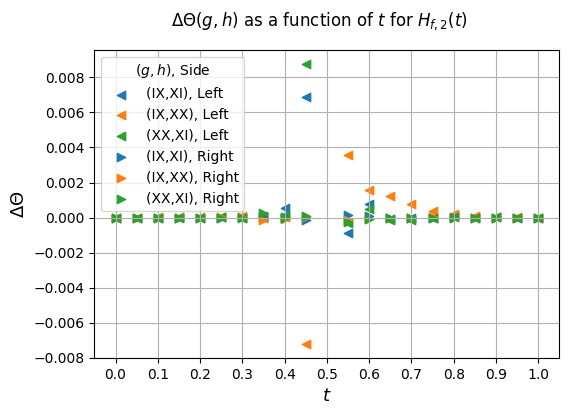

In [118]:
fig, ax = plt.subplots(figsize=(6,4))

for i, (marker, side_label) in enumerate(zip(markers, side_labels)):
    for j, (col, label) in enumerate(zip(colors, symmetry_pair_labels)):
        ax.scatter(
            interpolation_values,
            delta_gauge_invariant_proj_rep_angle[1, :, j, i],
            marker=marker,
            color=col,
            label = f'({label}), {side_label}'
        )

ax.xaxis.set_major_locator(MultipleLocator(0.1))

ax.grid()
ax.set_ylabel(r'$\Delta \Theta$', fontsize=13)
ax.set_xlabel('$t$', fontsize=13)

ax.legend(loc='upper left', title='$(g,h)$, Side')

fig.suptitle(r'$\Delta \Theta(g,h)$ as a function of $t$ for $H_{f,2}(t)$')

fig.savefig(r'plots/delta_proj_rep_angle_from_unitary_circuit_fermionc.png', dpi=200)

# Final plot

In [148]:
fp_triv_proj_rep_charges_array = np.stack(
    [left_fp_triv_proj_rep_charges_array, right_fp_triv_proj_rep_charges_array],
    axis=-1
)

fp_non_triv_proj_rep_charges_array = np.stack(
    [left_fp_non_triv_proj_rep_charges_array, right_fp_non_triv_proj_rep_charges_array],
    axis=-1
)

fp_charges_array = np.stack(
    [fp_triv_proj_rep_charges_array, fp_non_triv_proj_rep_charges_array],
    axis=0
)

In [149]:
fp_charges_array.shape

(2, 21, 2, 4, 2)

In [150]:
fp_charges_array = np.delete(fp_charges_array, 10, axis=1)

In [151]:
np.max(np.abs(fp_charges_array[..., 0] - fp_charges_array[..., 1]))

8.372702234514765e-15

In [152]:
fp_charges_array = fp_charges_array[..., 0]

In [153]:
fp_charges_array.shape

(2, 20, 2, 4)

In [154]:
np.max(np.abs(fp_charges_array[..., 0, :] - fp_charges_array[..., 1, :]))

0.05498764233237323

In [125]:
sub_fp_charges_array = fp_charges_array[..., 0, 1:]

In [126]:
sub_fp_charges_array.shape

(2, 20, 3)

In [127]:
fp_charges_array.shape

(2, 20, 2, 4)

In [128]:
sub_fp_charges_array = np.real(fp_charges_array[..., 1:])

In [129]:
mean_fp_charges_array = np.mean(sub_fp_charges_array, axis=2)

In [130]:
err_fp_charges_array = np.max(
    np.abs(sub_fp_charges_array - mean_fp_charges_array[..., np.newaxis, :]),
    axis=2
)

In [131]:
gauge_invariant_proj_rep_phases_array = proj_rep_phases_array[..., ::2, :]/proj_rep_phases_array[..., 1::2, :]

In [132]:
gauge_invariant_proj_rep_angle = np.imag(np.log(gauge_invariant_proj_rep_phases_array))
gauge_invariant_proj_rep_angle[gauge_invariant_proj_rep_angle<=-np.pi/2] += 2*np.pi

In [133]:
mean_gauge_invariant_proj_rep_angle = np.mean(gauge_invariant_proj_rep_angle, axis=(2,3))
max_gauge_invariant_proj_rep_angle = np.max(gauge_invariant_proj_rep_angle, axis=(2,3))
min_gauge_invariant_proj_rep_angle = np.min(gauge_invariant_proj_rep_angle, axis=(2,3))

min_max_gauge_invariant_proj_rep_angle = np.stack(
    [
        min_gauge_invariant_proj_rep_angle,
        max_gauge_invariant_proj_rep_angle
    ],
    axis=0
)

error_gauge_invariant_proj_rep_angle = (
    min_max_gauge_invariant_proj_rep_angle
    - mean_gauge_invariant_proj_rep_angle[np.newaxis, :]
)
error_gauge_invariant_proj_rep_angle = np.abs(error_gauge_invariant_proj_rep_angle)

In [134]:
raw_overlaps = [
    final_exps_triv_proj_rep,
    final_exps_non_triv_proj_rep
]

overlaps_array = np.zeros((2, 20, 3))

for i, d in enumerate(raw_overlaps):
    for j, t in enumerate(interpolation_values):
        for k in range(3):
            jw = right_fp_triv_proj_rep_charges_dict[(t, k+1)]
            mod_jw = 0 if jw == -1 else 1
            overlap = d[(t, mod_jw, k+1)]
            overlaps_array[i, j, k] = overlap

In [135]:
mean_gauge_invariant_proj_rep_angle

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.14159216e+00, 3.14159241e+00, 3.14159126e+00, 3.14159359e+00,
        3.14158570e+00, 3.14159917e+00, 3.14159819e+00, 3.14162702e+00,
        3.14169314e+00, 3.14301002e+00, 3.56933521e-04, 4.57778120e-04,
        1.52490646e-04, 1.02497423e-04, 5.69277942e-05, 4.99050884e-05,
        1.05640819e-05, 1.04931708e-05, 7.39988338e-07, 0.00000000e+00]])

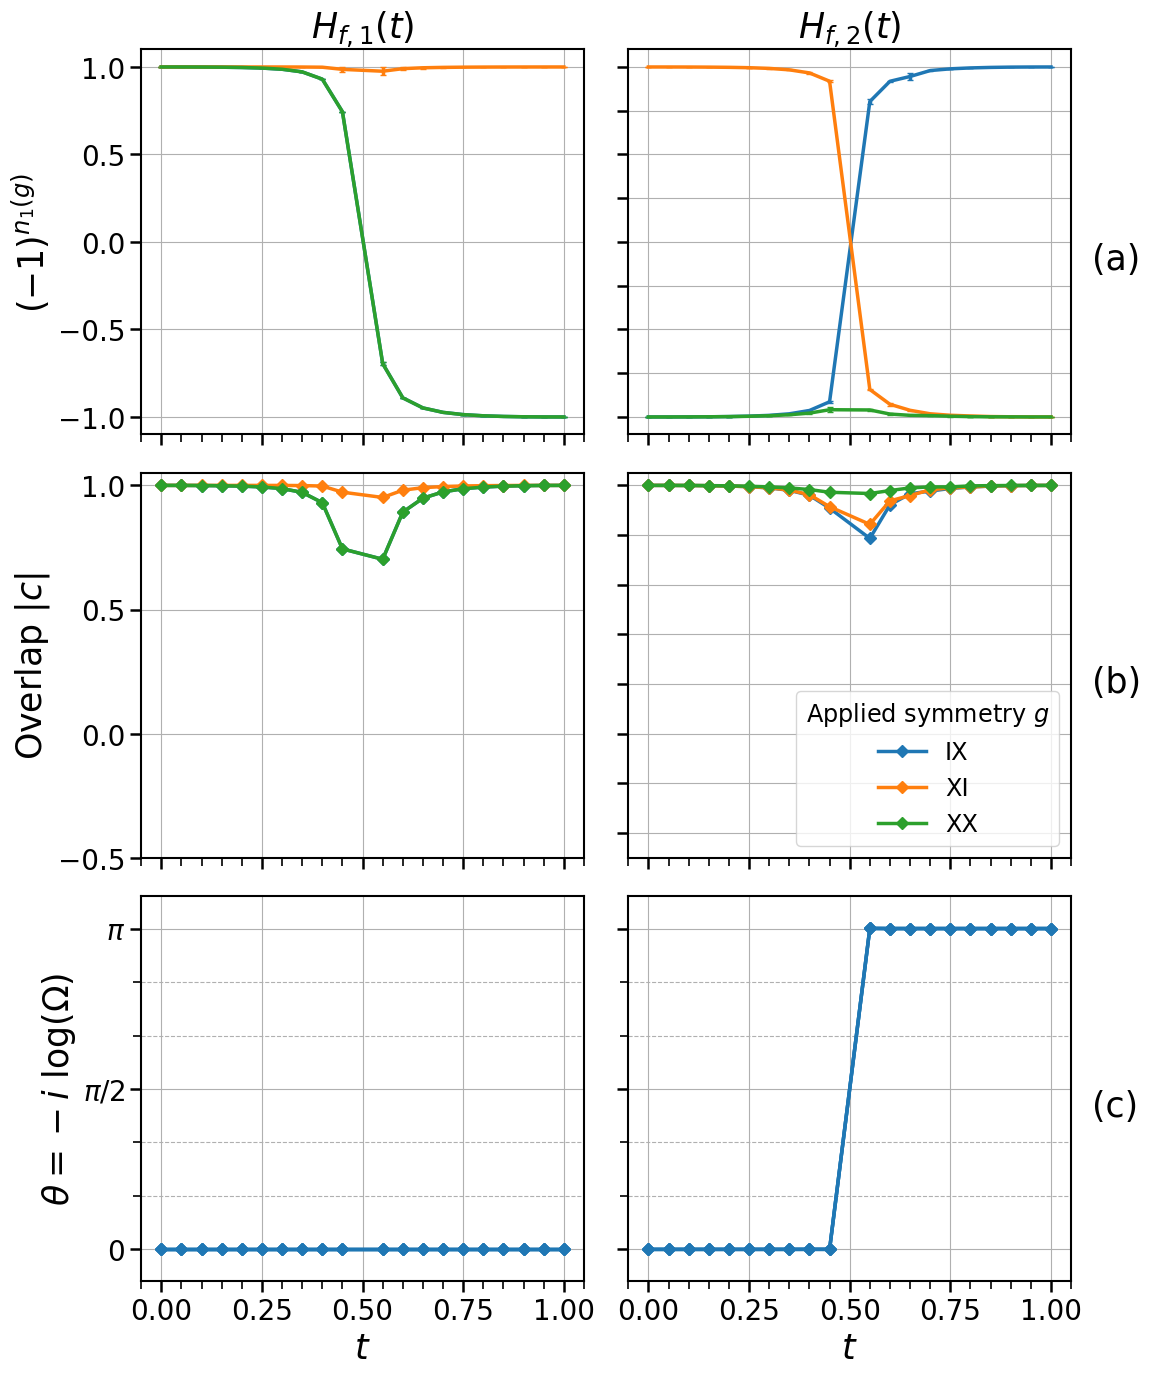

In [142]:
figure_label_fontsize=25
y_tick_label_fontsize=20
y_label_fontsize=25
x_tick_label_fontsize=20
x_label_fontsize=25
row_label_fontsize=25

axis_spine_linewidth = 1.5

major_tick_length = 8
major_tick_width = 1.8
minor_tick_length = 6
minor_tick_width = 1.2

plot_linewidth = 2.5

fig, ax_grid = plt.subplots(
    figsize=(12,16),
    ncols=2,
    nrows=3
)

for j, (col, label) in enumerate(zip(colors, symmetry_labels[1:])):
    for i, ax_row in enumerate(ax_grid):
        for k, ax in enumerate(ax_row):
            if i == 0:
                ax.errorbar(
                    interpolation_values[::-1],
                    mean_fp_charges_array[k, :, j],
                    yerr=err_fp_charges_array[k, :, j],
                    color=col,
                    label=label,
                    fmt='-',
                    capsize=2,
                    linewidth=phase_linewidth
                )

            if i==1:
                ax.plot(
                    interpolation_values[::-1], # I ordered this wrong at definition
                    overlaps_array[k, :, j],
                    color=col,
                    label=label,
                    marker='D',
                    linewidth=phase_linewidth
                )

            if i==2:
                ax.plot(
                    interpolation_values[::-1],
                    mean_gauge_invariant_proj_rep_angle[k],
                    color='tab:blue',
                    marker='D',
                    linewidth=phase_linewidth
                )

ax_grid[0][0].set_ylim(-1.1, 1.1)
ax_grid[0][1].set_ylim(-1.1, 1.1)
ax_grid[1][0].set_ylim(-0.5, 1.05)
ax_grid[1][1].set_ylim(-0.5, 1.05)

ax_grid[2][0].set_ylim((-0.1)*np.pi, np.pi*(1.1))
ax_grid[2][1].set_ylim((-0.1)*np.pi, np.pi*(1.1))

for i, row in enumerate(ax_grid):
    for j, ax in enumerate(row):
        ax.xaxis.set_major_locator(
            matplotlib.ticker.MultipleLocator(0.25)
        )
        ax.xaxis.set_minor_locator(
            matplotlib.ticker.MultipleLocator(0.05)
        )
        ax.grid()

        ax.grid(
            which='minor',
            axis='y',
            linestyle='--',
            zorder=-1e10
        )

        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(axis_spine_linewidth)

        ax.tick_params(
            axis='both',
            which='major',
            length=major_tick_length,
            width=major_tick_width
        )

        ax.tick_params(
            axis='both',
            which='minor',
            length=minor_tick_length,
            width=minor_tick_width
        )

        if i == 2:
            ax.set_yticks(
                np.linspace(0, np.pi, 3),
                labels=['$0$', '$\pi/2$', '$\pi$']
            )
            
            ax.set_yticks(
                [np.pi/6, np.pi/3, 2*np.pi/3, 5*np.pi/6],
                minor=True
            )

            ax.set_xlabel('$t$', fontsize=x_label_fontsize)

            ax.tick_params(
                axis='x',
                which='major',
                labelsize=x_tick_label_fontsize
            )

        if i == 0:
            ax.title.set_text(rf'$H_{{f,{j+1}}}(t)$')
            ax.title.set_fontsize(figure_label_fontsize)

        if j == 0:
            ax.tick_params(
                axis='y',
                which='major',
                labelsize=y_tick_label_fontsize
            )
        if j == 1:
            ax.set_yticklabels([])
            ax.yaxis.set_label_position("right")
        if i!= 2:
            ax.set_xticklabels([])

ax_grid[0][0].set_ylabel(r'$(-1)^{n_1(g)}$', fontsize=y_label_fontsize)
ax_grid[1][0].set_ylabel(r'Overlap $\vert c \vert$', fontsize=y_label_fontsize)
ax_grid[2][0].set_ylabel(r'$\theta=-i\ \log(\Omega)$', fontsize=y_label_fontsize)

for i, l in enumerate('abc'):
    ax_grid[i][1].set_ylabel(
        f'({l})',
        fontsize=y_label_fontsize,
        rotation='horizontal',
        ha='left',
        labelpad=15
    )

ax_grid[1][1].legend(
    loc='lower right',
    title='Applied symmetry $g$',
    fontsize='xx-large',
    title_fontsize='xx-large'
)

fig.subplots_adjust(wspace=0.1, hspace=0.1)

fig.savefig(
    r'plots/unitary_circuit_fermionic_results.png',
    dpi=200,
    bbox_inches='tight'
)

In [137]:
np.max(error_gauge_invariant_proj_rep_angle)

0.008624327688213196